In [32]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [33]:
#Reading in the dataframes

movie_info=pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
tmdb=pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets=pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
movie_gross=pd.read_csv("zippedData/bom.movie_gross.csv.gz")
reviews=pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

In [34]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [35]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [36]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [37]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [38]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


#### First step - cleaning the data.

In [39]:
#Cleaning tmdb to remove dupes. Adding a column including title and year to prepare for merge.
tmdb['title_and_year']=tmdb['original_title']+' ' +tmdb['release_date'].apply(lambda x: x[:4])
tmdb=tmdb.drop_duplicates(subset='id', keep='first')
tmdb=tmdb.drop_duplicates(subset='title_and_year', keep='first')
tmdb['title_and_year'].value_counts()

Frankie 2011                                                               1
Walking with the Dead 2015                                                 1
Real Ghosts UK 2010                                                        1
Kevin Smith: Burn in Hell 2012                                             1
Get on Up 2014                                                             1
                                                                          ..
Ancient Extraterrestrials: Aliens and UFOs Before the Dawn of Time 2013    1
Mythica: A Quest for Heroes 2014                                           1
Screaming in High Heels: The Rise & Fall of the Scream Queen Era 2011      1
Kidnap 2017                                                                1
Guns and Weed: The Road To Freedom 2011                                    1
Name: title_and_year, Length: 25415, dtype: int64

In [40]:
#Creating a matching column in movie_budgets to prepare for merge
movie_budgets['title_and_year']=movie_budgets['movie']+' ' +movie_budgets['release_date'].apply(lambda x: x[-4:])
movie_budgets['title_and_year'].value_counts()

Home 2009                                   2
The Best Man 1999                           1
John Wick: Chapter 3 â Parabellum 2019    1
A Street Cat Named Bob 2016                 1
Quigley Down Under 1990                     1
                                           ..
The R.M. 2003                               1
Stargate - The Ark of Truth 2008            1
Next 2007                                   1
12 Years a Slave 2013                       1
Gandhi, My Father 2007                      1
Name: title_and_year, Length: 5781, dtype: int64

In [41]:
#Creating numeric columns to represent Budget and Revenue
movie_budgets['revenue']=movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)
movie_budgets['budget']=movie_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)

#Removing duplicates
movie_budgets=movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

### Creating a new dataframe to compare revenue, genres, and ratings.

In [42]:
#Merging the two dataframes. Inner merge so that we can examine movies for which we have data on both budget and tmdb votes.
tmdb_and_budgets=pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')
#Dropping rows that have $0 as the value for revenue. Further research showed that many of these movies were released directly to streaming services.
tmdb_and_budgets=tmdb_and_budgets.loc[tmdb_and_budgets['revenue']!=0]
tmdb_and_budgets

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar 2009,2.776345e+09,425000000,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000,2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000,14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,6.559452e+08,300000000,20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,Justice League,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,18,"Nov 12, 2010",Tiny Furniture,"$50,000","$391,674","$424,149",Tiny Furniture 2010,4.241490e+05,50000,326,"[10749, 35, 18]",47607,en,Tiny Furniture,6.695,2010-11-12,Tiny Furniture,5.9,82
1591,20,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8.374000e+03,50000,16645,[99],322745,en,Counting,0.600,2015-07-31,Counting,8.3,3
1596,32,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3.632000e+03,40000,3576,[27],228550,en,Raymond Did It,1.675,2011-03-27,Raymond Did It,3.7,8
1599,38,"Mar 18, 2016",Krisha,"$30,000","$144,822","$144,822",Krisha 2016,1.448220e+05,30000,14760,[18],323929,en,Krisha,5.288,2016-03-18,Krisha,6.8,86


In this section we will conduct linear regression tests on the variables budget, vote average, and revenue to see how they are related.

In [43]:
X=tmdb_and_budgets['budget']
y=tmdb_and_budgets['vote_average']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.58
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.32e-06
Time:                        00:46:12   Log-Likelihood:                -1854.5
No. Observations:                1504   AIC:                             3713.
Df Residuals:                    1502   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2627      0.028    226.929      0.000       6.209       6.317
budget      1.869e-09   3.85e-10      4.856      0.000    1.11e-09    2.62e-09
==============================================================================
Omnibus:                       32.028   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.793
Skew:                          -0.290   Prob(JB):                     6.21e-09
Kurtosis:                       3.516   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

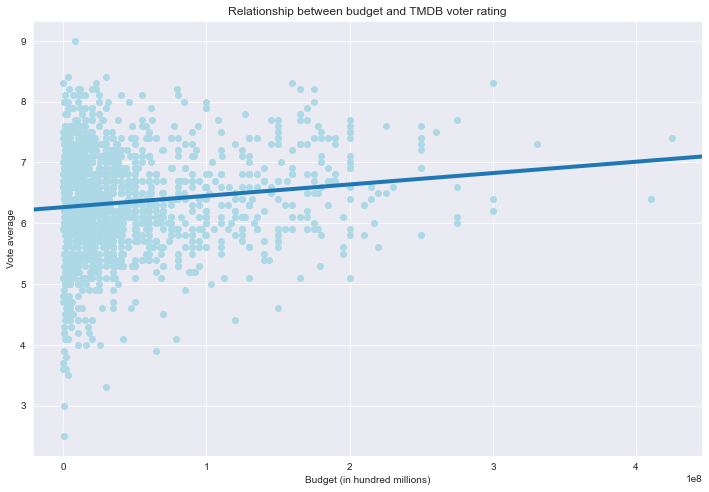

In [44]:
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(X, y, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship between budget and TMDB voter rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

In [45]:
X=tmdb_and_budgets['budget']
y=tmdb_and_budgets['revenue']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2533.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:46:12   Log-Likelihood:                -30421.
No. Observations:                1504   AIC:                         6.085e+04
Df Residuals:                    1502   BIC:                         6.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.404e+06    4.9e+06     -1.921      0.055    -1.9e+07       2e+05
budget         3.4360      0.068     50.332      0.000       3.302       3.570
==============================================================================
Omnibus:                      808.821   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13310.254
Skew:                           2.128   Prob(JB):                         0.00
Kurtosis:                      16.938   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

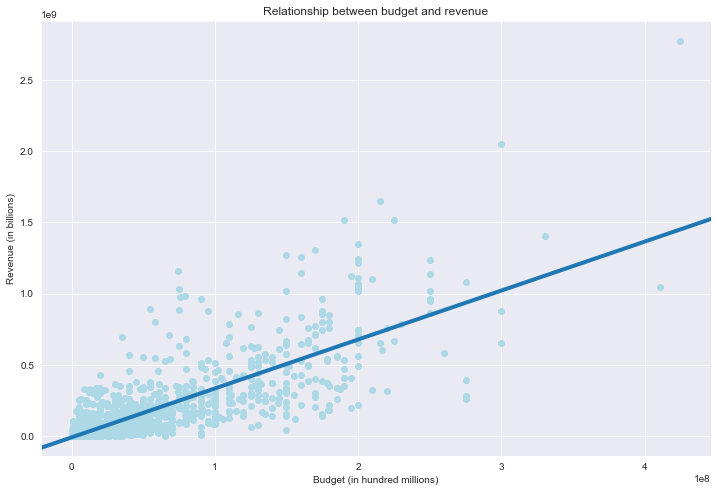

In [46]:
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(X, y, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

In [47]:
X=tmdb_and_budgets['budget']
y=tmdb_and_budgets['revenue']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2533.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:46:12   Log-Likelihood:                -30421.
No. Observations:                1504   AIC:                         6.085e+04
Df Residuals:                    1502   BIC:                         6.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.404e+06    4.9e+06     -1.921      0.055    -1.9e+07       2e+05
budget         3.4360      0.068     50.332      0.000       3.302       3.570
==============================================================================
Omnibus:                      808.821   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13310.254
Skew:                           2.128   Prob(JB):                         0.00
Kurtosis:                      16.938   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will examine the most common studios from the movie info dataset.

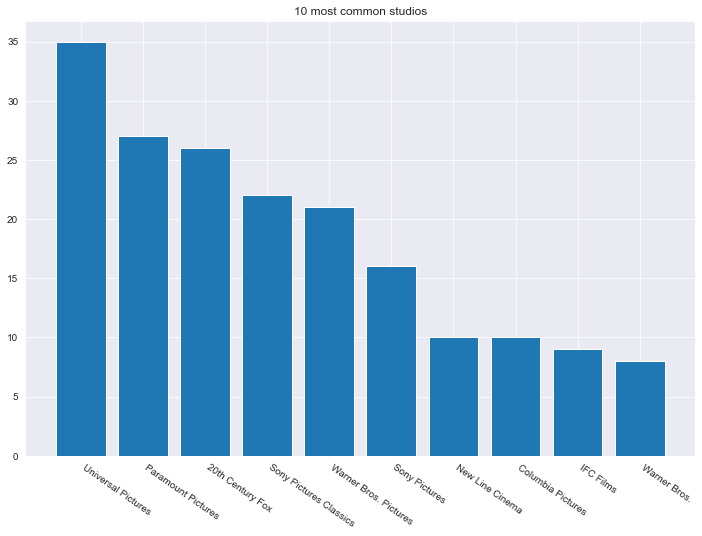

In [48]:
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(movie_info['studio'].value_counts()[:10].index, movie_info['studio'].value_counts()[:10].values)
ax.set_xticklabels(movie_info['studio'].value_counts()[:10].index, rotation=-35, ha='left')
ax.set_title('10 most common studios');

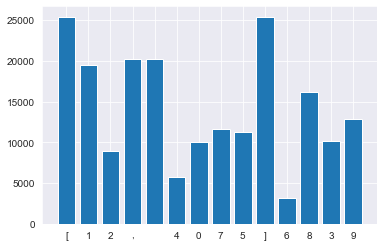

In [49]:
genre_counts={}
for row in tmdb['genre_ids']:
    for l in row:
        if l in genre_counts.keys():
            genre_counts[l]+=1
        else:
            genre_counts[l]=1

fig, ax=plt.subplots()
ax.bar(genre_counts.keys(), genre_counts.values());

Examining year and revenue:

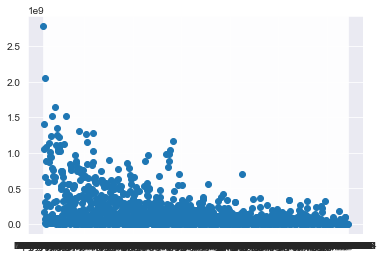

In [50]:
fig, ax=plt.subplots()
ax.scatter(tmdb_and_budgets['release_date_x'], tmdb_and_budgets['revenue'])

As we will show below, year is not a good predictor of revenue.

In [51]:
tmdb_and_budgets['year']=tmdb_and_budgets['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year=tmdb_and_budgets.groupby('year')['revenue'].mean()

In [52]:
X=revenue_by_year.index
y=revenue_by_year.values
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8618
Date:                Tue, 20 Jun 2023   Prob (F-statistic):              0.359
Time:                        00:46:30   Log-Likelihood:                -790.97
No. Observations:                  38   AIC:                             1586.
Df Residuals:                      36   BIC:                             1589.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.987e+09   5.59e+09     -0.891      0.379   -1.63e+10    6.36e+09
x1            2.6e+06    2.8e+06      0.928      0.359   -3.08e+06    8.28e+06
==============================================================================
Omnibus:                       49.578   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.245
Skew:                           3.119   Prob(JB):                     2.02e-49
Kurtosis:                      13.134   Cond. No.                     2.53e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will examine the relationship between genres and revenue by creating a dictionary. 

In [53]:
#reset index due to dropping rows
tmdb_and_budgets.reset_index(inplace=True)

#removing unnecessary columns
tmdb_and_budgets.drop(['index', 'id_x', 'id_y', 'Unnamed: 0'], axis=1, inplace=True)

tmdb['genre_ids']=tmdb['genre_ids'].str.split()
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].str.split()

tmdb_and_budgets.tail()

,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,genre_ids,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count,year
1499,"Nov 12, 2010",Tiny Furniture,"$50,000","$391,674","$424,149",Tiny Furniture 2010,424149.0,50000,"[[10749,, 35,, 18]]",en,Tiny Furniture,6.695,2010-11-12,Tiny Furniture,5.9,82,2010
1500,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8374.0,50000,[[99]],en,Counting,0.600,2015-07-31,Counting,8.3,3,2015
1501,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3632.0,40000,[[27]],en,Raymond Did It,1.675,2011-03-27,Raymond Did It,3.7,8,2011
1502,"Mar 18, 2016",Krisha,"$30,000","$144,822","$144,822",Krisha 2016,144822.0,30000,[[18]],en,Krisha,5.288,2016-03-18,Krisha,6.8,86,2016
1503,"Sep 1, 2015",Exeter,"$25,000",$0,"$489,792",Exeter 2015,489792.0,25000,"[[53,, 27]]",en,Exeter,5.934,2015-03-26,Exeter,4.7,121,2015


In [54]:
def genre_fixer(g_i):
    if len(g_i)>1:
        cleaned_g_i=[]
        cleaned_g_i.append(g_i[0].split('[')[1].split(',')[0])
        for g in g_i[1:-1]:
            cleaned_g_i.append(g.split(',')[0])
        cleaned_g_i.append(g_i[-1].split(']')[0])
        return cleaned_g_i
    elif len(g_i)==1:
        cleaned_g_i=[]
        cleaned_g_i.append(g_i[0].split('[')[1].split(']')[0])
        return cleaned_g_i
    
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].apply(genre_fixer)

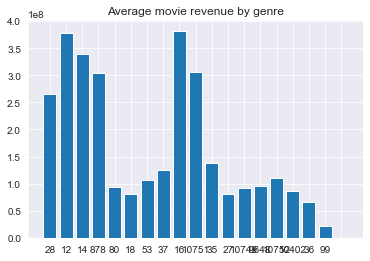

In [55]:
genre_and_revenue={}
for row in tmdb_and_budgets.index:
    g_ids=tmdb_and_budgets.iloc[row]['genre_ids']
    rev=tmdb_and_budgets.iloc[row]['revenue']
    for g in g_ids:
        if g in genre_and_revenue.keys():
            genre_and_revenue[g]=np.append(genre_and_revenue[g], rev)
        else:
            genre_and_revenue[g]=np.array([rev])

genre_and_revenue_average={}
for g in genre_and_revenue.keys():
    genre_and_revenue_average[g]=genre_and_revenue[g].mean()

fig, ax=plt.subplots()
ax.bar(genre_and_revenue_average.keys(), genre_and_revenue_average.values())
ax.set_title('Average movie revenue by genre');

In [56]:
#checking to see if genre has a statistically significant impact on revenue
stats.f_oneway(*genre_and_revenue.values())

F_onewayResult(statistic=42.42335720539169, pvalue=1.312681604772548e-136)

Since the p-value is extremely small and less than 0.05, we conclude that genre does have a statistically significant impact on revenue.

In [57]:
tmdb_and_budgets['revenue_to_budget']=tmdb_and_budgets['revenue']/tmdb_and_budgets['budget']
tmdb_and_budgets

,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,genre_ids,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count,year,revenue_to_budget
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar 2009,2.776345e+09,425000000,"[28, 12, 14, 878]",en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,2009,6.532577
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000,"[12, 28, 14]",en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571,2011,2.546673
2,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000,"[28, 12, 878]",en,Avengers: Age of Ultron,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457,2015,4.243841
3,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000,"[12, 28, 14]",en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,2018,6.827114
4,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,6.559452e+08,300000000,"[28, 12, 14, 878]",en,Justice League,34.953,2017-11-17,Justice League,6.2,7510,2017,2.186484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,"Nov 12, 2010",Tiny Furniture,"$50,000","$391,674","$424,149",Tiny Furniture 2010,4.241490e+05,50000,"[10749, 35, 18]",en,Tiny Furniture,6.695,2010-11-12,Tiny Furniture,5.9,82,2010,8.482980
1500,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8.374000e+03,50000,[99],en,Counting,0.600,2015-07-31,Counting,8.3,3,2015,0.167480
1501,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3.632000e+03,40000,[27],en,Raymond Did It,1.675,2011-03-27,Raymond Did It,3.7,8,2011,0.090800
1502,"Mar 18, 2016",Krisha,"$30,000","$144,822","$144,822",Krisha 2016,1.448220e+05,30000,[18],en,Krisha,5.288,2016-03-18,Krisha,6.8,86,2016,4.827400


## Examining return on investment.
We will examine the return on investment for a movie by dividing the box office revenue by the budget.

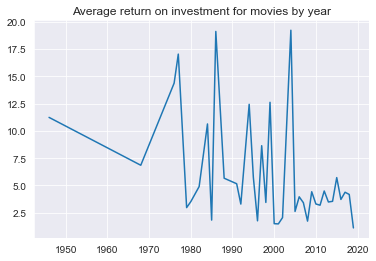

In [58]:
#examining return on investment over time
fig, ax=plt.subplots()
ax.plot(tmdb_and_budgets.groupby('year')['revenue_to_budget'].mean().index, tmdb_and_budgets.groupby('year')['revenue_to_budget'].mean().values)
ax.set_title('Average return on investment for movies by year');

## Which movie genres produce the highest return on investment?

In [59]:
genre_rois={}

for row in tmdb_and_budgets.index:
    g_ids=tmdb_and_budgets.iloc[row]['genre_ids']
    rtb=tmdb_and_budgets.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g]=np.append(genre_rois[g], rtb)
        else:
            genre_rois[g]=np.array([rtb])

genre_rois_average={}
for g in genre_rois.keys():
    genre_rois_average[g]=genre_rois[g].mean()

genre_rois_average

{'28': 2.8445543476074677,
 '12': 3.256334414162225,
 '14': 3.2480465355054586,
 '878': 3.607353759756162,
 '80': 2.702837128108868,
 '18': 3.2386691909339707,
 '53': 5.371078105187498,
 '37': 1.6573053339634713,
 '16': 3.88630585673147,
 '10751': 3.5099992705588554,
 '35': 3.5129645718451865,
 '27': 11.009585157813289,
 '10749': 3.8883719658041738,
 '9648': 5.374170979124497,
 '10752': 2.356601874654575,
 '10402': 3.2331544464826396,
 '36': 2.516939570721482,
 '99': 3.2652166397885694,
 '': 0.0033696666666666666}

#### Does genre have a statistically significant impact on return on investment?
Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [60]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=5.349619582079299, pvalue=1.5878366005252943e-12)

Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

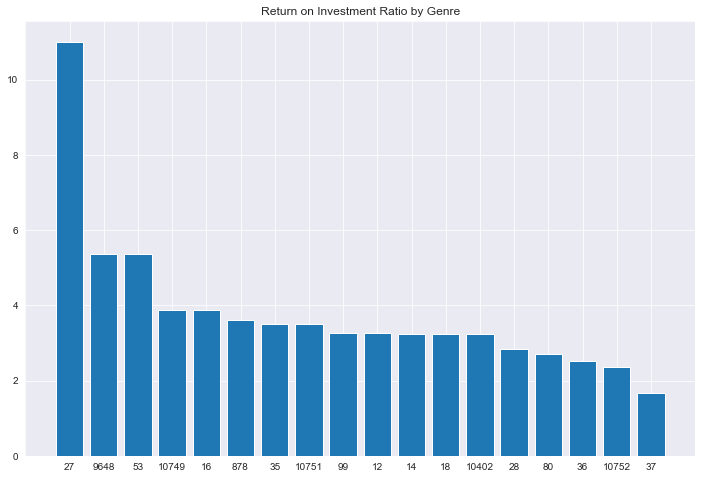

In [61]:
genre_ids=list(genre_rois_average.keys())
rois=list(genre_rois_average.values())
genres_and_rois=pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.drop(genres_and_rois.index[18], inplace=True)
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre');

We can see that genre 27 has the highest return on investment, followed by genres 9648 and 53.

## What about for current movies only? Are the results different?
Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

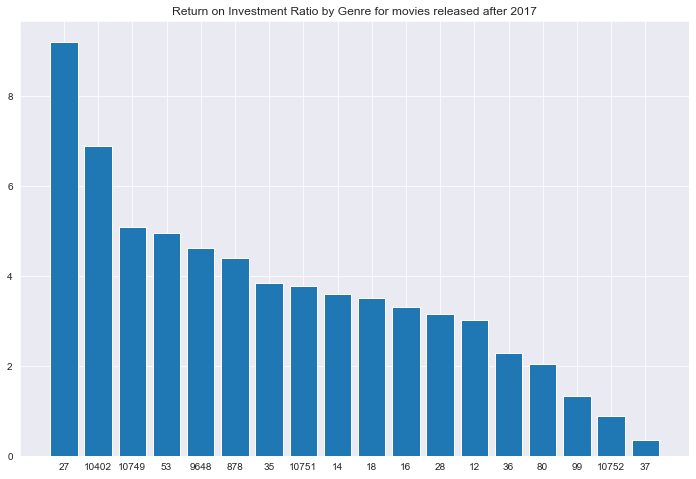

In [62]:
#repeating the same steps as above, but for new movies only

new_movies=tmdb_and_budgets.loc[tmdb_and_budgets['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017');


Genre 27 still has the highest return on investment, although the gap is not as wide when filtered to new movies only. Genres 10402 and 10749 have also done well recently in the box office.

The top genres we recommend are 27, 10402, 10749, 53, and 9648.

## So now that we know what genres are the most profitable, what studios should we pair with? How about directors?